<a href="https://colab.research.google.com/github/jojoroy/MScDis/blob/main/GPMH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building some intuition about the $L^2$ based risk approach.

The general idea is the following:  we employ a surrogate GP model for the log likelihood of a positive density $\pi$, i.e.
we assume that
$$
    \pi_f(x) = \frac{\exp(f(x))\pi_0(x)}{\int \exp(f(x'))\pi_0(x')\,dx'}.
$$
where $\pi_0$ is a prior distribution which is assumed to be tractable.   We denote by $\widetilde{\pi}_f$ to be the unnormalised posterior distribution.

#### Approach 1:  $L^2$ between unnormalised measures loss.

This is the idea of [Sinsbeck and Nowak](https://epubs.siam.org/doi/abs/10.1137/15M1047659), however it has been adjusted to make it comparable to our approach.  While in their paper they considered a surrogate for the actual forward problem, in this work we surrogate the likelihood directly.   This is directly discussed in [Jarvenpaa et al, 2021](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-1/Parallel-Gaussian-Process-Surrogate-Bayesian-Inference-with-Noisy-Likelihood-Evaluations/10.1214/20-BA1200.full), although the focus of that paper is an alternative loss function.   

We wish to derive an optimal estimator for the unnormalised posterior $\widetilde{\pi}_f$ using Bayesian decision theory.  To this end, we consider the integrated quadratic loss function:
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int_{X} |\widetilde{\pi}_1(x) - \widetilde{\pi}_2(x)|^2\,dx,
$$
where we assume that both $\widetilde{\pi}_1$ and $\widetilde{\pi}_2$ are square-integrable.

The optimal bayes estimator is the minimiser of the expected loss, i.e.
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\widetilde{\pi}_f(x) - d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\widetilde{\pi}_f(x) - d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator can be derived and shown to be
$$
    \widetilde{\pi}^* =  \mathbb{E}_{f| D}[\widetilde{\pi}_f].
$$

The Bayes risk is the integrated variance;
$$
\int {Var}_{f | D}[\widetilde{\pi}_f(x)]\,dx.
$$

You can derive closed-form expressions for both in the GP case, namely
$$
   \mathbb{E}_{f| D}[\widetilde{\pi}_f] = \pi_0(x)e^{m(x) + s^2(x)},
$$
and
$$
 {Var}_{f | D}[\widetilde{\pi}_f(x)] = \pi_0(x)^2 e^{2m(x) + s^2(x)}(e^{s^2(x)} - 1),
$$
where $m$ and $s$ are the pointwise mean and standard deviation of the conditioned GP $f | D$.  

#### Approach 2: $L^2$ between the scores.

Ultimately, we want the surrogate model to perform MCMC.  If we're using a gradient based approach, then only really care about the score function, i.e. the gradient of the log likelihood.   It makes sense to consider a loss function which is only penalising errors in the gradient -- this has a lot of advantages:  we no longer have to worry about the normalisation constant, and it simplifies some calculations significantly.

We consider an optimal estimator for the score function $\nabla \log \pi_f$, i.e.
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int |\nabla \log \widetilde{\pi}_1(x) - \nabla \log \widetilde{\pi}_2(x)|^2.
$$
The optimal estimator is then
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\nabla \log\widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\nabla \log \widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator then satisfies
$$
\nabla \log \widetilde{\pi}^*(x) = \nabla \mathbb{E}_{f | D } f(x) = \nabla  m(x),
$$
so that
$$
    \widetilde{\pi}^*(x) \propto e^{m(x)}.
$$
The risk / variance of the estimator is
$$
    \mathbb{E}_{f|D}\int |\nabla \log \pi_f(x) - \nabla m(x)|^2 \,dx =  \mathbb{E}_{f|D}\int |\nabla f(x)- \nabla m(x)|^2 \,dx,
$$
which is
$$
    \int Tr(Cov(\nabla f(x) |D))\,dx = \int \nabla_1 \cdot \nabla_2 k_{D}(x, x)\,dx.
$$
The most important point is that this term is independent of the evaluations of the true posterior.  This means that no active learning is feasible in this instance, and instead we would do a single offline point evaluation stage.


#### Approach 3: Distances between the measures

An alternative approach which constrasts with the local one considered previously, would be to require that the estimator is close to the surrogate in terms of distances on probability distributions.  For example, we could use KL divergence.

Consider
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(d, \pi_f) \\
 &=  \int d(x) \log d(x)\,dx - \int d(x) m_n(x)\,dx,
 \end{aligned}
$$
using the fact that $\int d(x)\,dx = 1$.  This has minimiser:
$$
d^*(x) \propto e^{m_n(x)}
$$

The risk is
$$
\mathbb{E}_{f|D}KL(d^*, \pi_f) = \int\frac{ e^{m_n(x)}}{Z_n}  m_n(x)\,dx - \int \frac{e^{m_n(x)}}{Z_n} m_n(x)\,dx = 0.
$$

(Am I making a mistake here?  This seems unlikely to be true?)

Alternatively, we could consider the Reverse-KL as a loss
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(\pi_f, d) \\
 &=   \mathbb{E}_{f|D}\left[\int \pi_f \log \pi_f\,dx - \int \pi_f \log d(x)\,dx\right], \\
 &=   \int \mathbb{E}_{f|D}[\pi_f \log \pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C +  \int \mathbb{E}_{f|D}[\pi_f] \log \mathbb{E}_{f|D}[\pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C + KL(\mathbb{E}_{f|D}[\pi_f] , d),
 \end{aligned}
$$
where $C$ is a constant.  The optimal estimator is therefore
$$
d^* = \mathbb{E}_{f|D}[\pi_f].
$$

### Our Proposed Approach

We propose the following iterative scheme

Find $p_n$ such that
$$
    \arg\max_{x} \mathbb{E}_{z \sim f(x)|D}\mathbb{E}_{f|D }D(p_{D \cup \lbrace (x,y)\rbrace } \,|\, p_{D})
$$
Choosing KL divergence we have objective function
$$
\mathbb{E}_{z \sim f(x)|D} \mathbb{E}_{f|D }\int \frac{e^{f_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{f_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$

With Fisher divergence, we get a similar expression, but with gradients in the integrand.   If we can argue that we can replace $f$ with it's mean, then this simplifies somewhat:
$$
\mathbb{E}_{z \sim f(x)|D} \int \frac{e^{m_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{m_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$
It is unclear how we can justify this assumption, and further how to cleanly deal with the expectation wrt to $z$.

### Exploring the $L^2$ loss based estimator and its risk.   

We implement the idea of Sinsbeck and Nowak, but adjust it to work in our setting where we have a surrogate for the likelihood directly.

In [ ]:
pip install jaxtyping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
pip install gpjax==0.8.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.2/197.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: optax
    Found existing installation: optax 0.2.2
    Uninstalling optax-0.2.2:
      Successfully uninstalled optax-0.2.2


In [ ]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

from jax.scipy.special import logsumexp
from jax.scipy.stats import norm as norm
import cola


key = jr.PRNGKey(123)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [ ]:
import numpy as np
#from jax.scipy.special import log1p

In [ ]:
# Define the function to be sampled from.

# this is the log-likelihood of a Gaussian mixture with means at -2 and 2 and variance 0.1
l = jit(lambda x:  jnp.log(0.5 * jnp.exp(-(x-2)**2/0.2) + 0.5 * jnp.exp(-(x +2)**2/ 0.2)))

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = l(xtest)

D = gpx.Dataset(xtest, ytest)

This is just some test code to check that the Gaussian process does regression properly.

In [ ]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


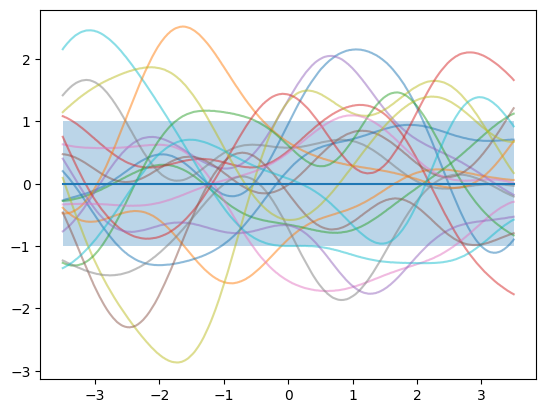

In [ ]:
# generate some test points
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)

# predict from the prior
prior_dist = prior.predict(xtest)

# generate samples from the prior and do prediction
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))

# plot the prior samples
fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, label="Prior samples")
ax.plot(xtest, prior_mean,  label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    label="Prior variance",
)
# ax.legend(loc="best")

In [ ]:
# Generate the likelihood

likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

# Generate the posterior predictive distribution
latent_dist = posterior.predict(xtest, train_data=D)
predictive_dist = posterior.likelihood(latent_dist)

# Extract the mean and variance of the posterior predictive distribution
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [ ]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=obs_stddev)
    likelihood = likelihood.replace_trainable(obs_stddev=False)
    posterior = prior * likelihood

    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, _ = gpx.fit(
        model=posterior,
        objective=negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

To select a new point, Sinsbeck and Nowak make use of the L2 risk function (also Jarvenpaa et al, 2021), as follows:

$$
    R(\theta^*) = \mathbb{E}_{y \sim f(x^*) |D}\int e^{2m_t(x; x^*, y) + s_t^2(x; x^*, y)}(e^{s_t^2(x; x^*, y)} - 1),
$$
where $m_t(x; x^*, y)$ is the posterior mean of the GP after conditioning on the current data set $D$ along with an additional point $(x^*, y)$.  The variance $s_t^2(x; x^*, y)$ is defined analogously.

To compute the expectation, we do Monte Carlo using exact samples of $y \sim f(x^*) |D$.  We typically use just $10$ samples.  Unsurprisingly this is very slow, and little bit unstable.

To compute the integral over $x$, we evaluate the gp over a fine mesh and use Euler integration.   This obviously cannot scale beyond a few dimensions.

So can we avoid the need to compute the expectation with respect to y?   

To do so, we follow the approach / derivations in [Jarvenpaa, 2021] which derive closed form distributions for the GP mean and GP variance.  

More specifically we can show that the loss function becomes
$$
        R(\theta^*) = \int e^{2m_t(x) + s_t^2(x)}(e^{\tau_t(x, x^*)} - 1),
$$
where
$$
\tau_t(x, x^*) = \frac{k_t(x, x^*)^2}{s_t(x^*)^2 + \sigma^2},
$$
where $\sigma^2$ is the variance of the observational noise and where

* $k_t$ is the kernel (i.e. two-point covariance) of the GP conditioned on $D$.
* $m_t$ is the mean of the GP conditioned on $D$.
* $s_t^2$ is the variance of the GP conditioned on $D$.

In [ ]:
# this computes k_t, the two point covariance function
def two_point_covariance(x_current, X, Y, posterior, jitter=1e-6):
    """Compute the two point covariance function.
    Args:
        x_current: current point
        X: input data
        Y: output data
        posterior: posterior distribution
        jitter: jitter for numerical stability
    Returns:
        covariance: two point covariance function
    """
    kernel = posterior.prior.kernel
    obs_noise = posterior.likelihood.obs_stddev**2

    Kxx = kernel.gram(x_current)
    Kxx += cola.ops.I_like(Kxx) * jitter

    #Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
    #Sigma = cola.PSD(Sigma)

    KXY = kernel.cross_covariance(X, Y)
    KXx = kernel.cross_covariance(X, x_current)
    KxY = kernel.cross_covariance(x_current, Y)


    Sigma_inv_KxY = cola.solve(Kxx, KxY)

    covariance = KXY - jnp.matmul(KXx, Sigma_inv_KxY)

    return covariance

In [ ]:
# Compute the loss function for the next point
def loss_fast(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """

    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean().reshape(-1,1)
    p_std = predictive_dist.stddev().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)

    # compute the tau2 term
    tau2 = C**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    # the log sum exp trick is used to avoid numerical issues.
    # basically this computes
    # log \int e^{2*p_mean + 2*p_std^2} - e^{2*p_mean + p_std^2 + tau2(x^*)} dx
    log_loss = logsumexp(2.0*p_mean + 2.0*p_std**2, axis=0) - logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    return(log_loss)

In [ ]:
# This removes the terms that don't depend on x_new
def loss_fast2(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)

    #latent_dist = posterior.predict(x_grid, train_data=D)
    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    #p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std_new = predictive_dist.stddev()#.reshape(-1,1)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)
    p_std = predictive_dist.stddev().reshape(-1,1)
    p_mean = predictive_dist.mean().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)

    tau2 = C**2/(p_std_new**2 + obs_stddev**2)
    #print(np.shape(tau2))
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)
    print(np.shape(log_loss))
    return(log_loss)

How do we interpret the loss function?

1. The $\mu_n$ weights points which have mean (exploitation)
2. The $\sigma_n^2$ weights points which have higher absolute variance (exploration).
3. The main term $\tau^2(a,b)$ is large when there's a strong correlation between $a$ and $b$, weighted by their standard deviation.

The tau effectively acts as a "bump" function which aggregates points around the design point.

In summary -- preferred design points will lie in a neighbourhood of large $\mu_n$ or large $\sigma^2_n$, thus effectively performing exploration / exploitation.

In [ ]:
# Let us test the speed of the new loss function

obs_stddev = 1e-3
num_samples=10

x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
x_current = jnp.array([[-3.0, 3.0]]).T
y_current = l(x_current)

test_points = jnp.arange(-5.0, 5.0, 0.1)


  0%|          | 0/1000 [00:00<?, ?it/s]

(80,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(79,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(78,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(77,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(76,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(75,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(74,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(73,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(72,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(71,)


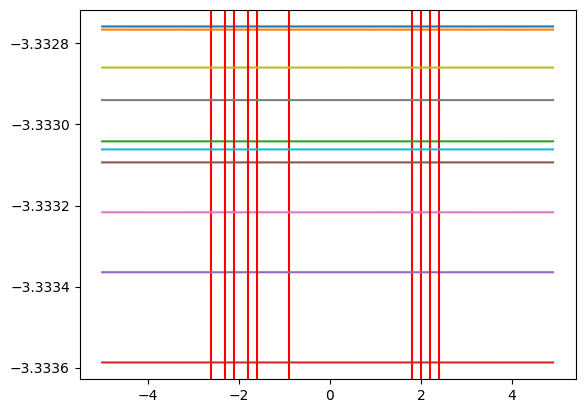

In [ ]:
m=0
while m<10:
  test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
  test_point_utilities = loss_fast2(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)

  plt.plot(test_points, test_point_utilities)

  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  y_new = l(x_new)
  x_current = jnp.vstack([x_current, x_new])
  x_current = x_current.sort(axis=0)
  y_current =l(x_current)

  plt.axvline(x_new, color='red')
  m+=1


(90,)


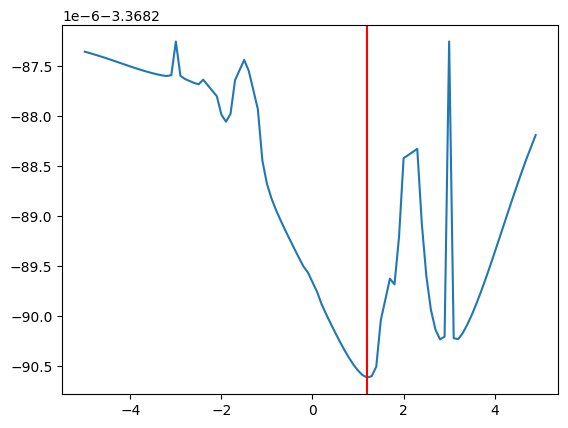

In [ ]:
test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
test_point_utilities = loss_fast2(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)

plt.plot(test_points, test_point_utilities)

i = jnp.argmin(jnp.array(test_point_utilities))
x_new = test_points[i]
y_new = l(x_new)
x_current = jnp.vstack([x_current, x_new])
x_current = x_current.sort(axis=0)
y_current =l(x_current)

plt.axvline(x_new, color='red')

# this takes about 2 seconds to run on my M1 Macbook Pro (2020)
# this takes about 2 seconds to run on my M1 Macbook Pro (2020)

  0%|          | 0/1000 [00:00<?, ?it/s]

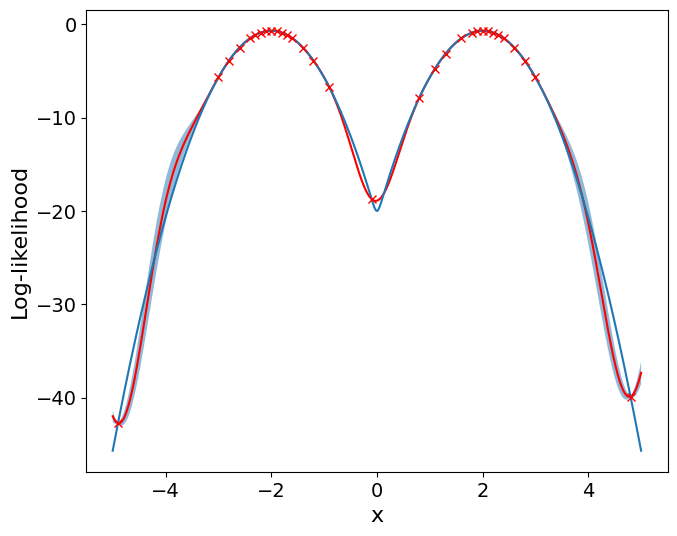

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=True, obs_stddev=obs_stddev)

plt.figure(figsize=(7.5,6))
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),l(xtest))
plt.plot(x_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
plt.xlabel('x',fontsize=16)
plt.ylabel('Log-likelihood',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('32pts.pdf')
plt.show()

### Computational Cost

Every macro step of the algorithm is $O(N^3)$, where $N$ is the number of points evaluated
Within each macro-step you have cost $M*N^2$, where $M$ is the number of MCMC samples generated.

# 2023 paper

In [ ]:
# This removes the terms that don't depend on x_new
def loss_2023paper(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [ ]:
def epsilon_gamma(m,v,u):
  return norm.cdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
def log_epsilon_gamma(m,v,u):
  return norm.logcdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [ ]:
#PRONE TO INSTABILITY
def expected(m,v):
  if m>=0:
    return norm.cdf(-m/v)-jnp.exp(m+(v**2)/2)*norm.cdf(-(m+v**2)/v)
  else:
    return norm.cdf(m/v)+jnp.exp(m+(v**2)/2)*(norm.cdf(-(m+v**2)/v)-2*norm.cdf(-v))

In [ ]:
def expected1(m,v):
  u = jnp.arange(0,1,0.05)
  return logsumexp(log_epsilon_gamma(m,v,u))

In [ ]:
# define x current and y_current
x_current = jnp.array([[-5., 5.]]).T
y_current = l(x_current)
# set up empty mh_samples
N = 3000
mh_samples=np.zeros(N)
mh_samples[0]=0
epsilon = 0.3
obs_stddev=1e-3

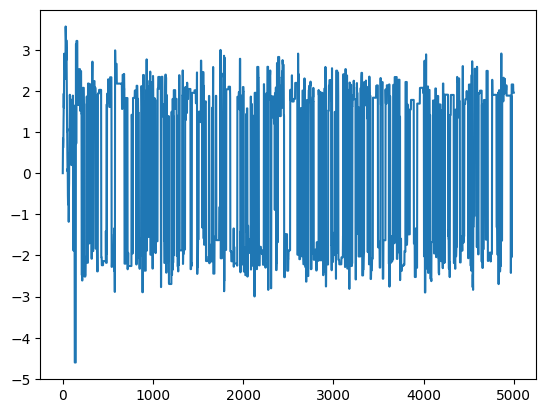

In [ ]:
plt.plot(mh_samples)

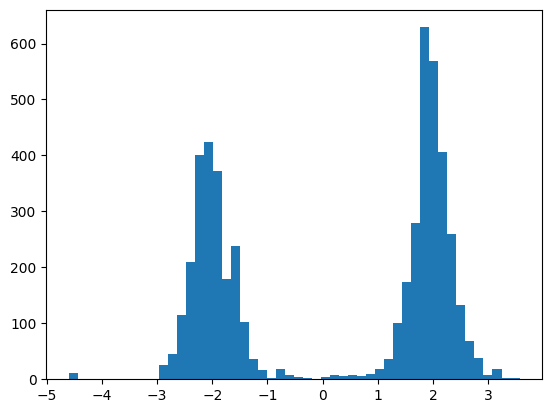

In [ ]:
plt.hist(mh_samples,bins=50)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

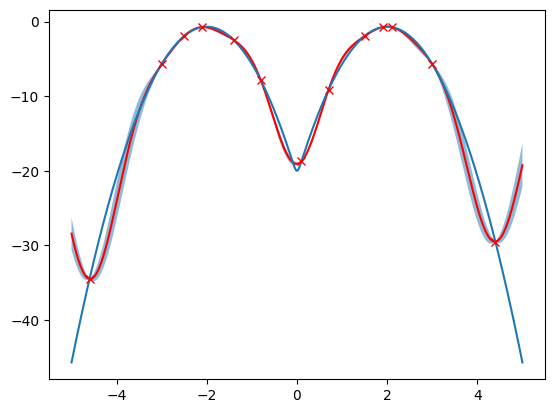

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=True, obs_stddev=obs_stddev)
plt.figure(figsize=())
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),l(xtest))
plt.plot(x_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
plt.show()

In [ ]:
#make new eval posterior for this situation
def gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  mean=m[1]-m[0]
  if x_prop >5 or x_prop<-5:
    mean=-10000
  return mean,v[0]**2 + v[1]**2 - 2*C-2*posterior.likelihood.obs_stddev**2

In [ ]:
# define x current and y_current
x_current = jnp.array([[-3., 3.]]).T
y_current = l(x_current)
# set up empty mh_samples
N = 5000
mh_samples=np.zeros(N)
q_means=np.zeros(N)
mh_samples[0]=0
q_cov=0.1
epsilon = 0.05
obs_stddev=1e-3
t_0=100
proposal='normal'

In [ ]:
np.random.seed(10)
D = gpx.Dataset(x_current, y_current)

posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
for i in range(1,N):
  if i > t_0:
    q_cov=((i-2)/(i-1))*q_cov + ((2.4**2)/((i-1)))*((i-1)*(q_means[i-2]**2)-i*q_means[i-1]**2+(mh_samples[i-1]*mh_samples[i-1])+ 1e-6)
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform() - 0.5)*6 + mh_samples[i-1]
  else:
    x_prop=np.random.normal(mh_samples[i-1],np.sqrt(q_cov))
  u = np.random.uniform()
  x_now=mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)

  print(epsilon_gamma(m,v,u),expected(m,v),'Current',x_now,'proposed',x_prop)

  #while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 150:
  while expected(m,v) > epsilon and np.size(x_current) < 150:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    x_grid = jnp.vstack([x_now,x_prop]).reshape(-1,1)

    test_points = jnp.arange(-5, 5, 0.1)
    '''
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    ls = posterior.prior.kernel.lengthscale
    print('lengthsxale:',ls)
    test_points = jnp.arange(min-round(5*ls,1), round(ls*5,1), 0.1)
    '''
    test_points= jnp.round(test_points,1)
    test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    test_points= jnp.round(test_points,1)
    #print(np.shape(test_points))
    test_point_utilities = loss_2023paper(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)
    '''
    temp_flag = np.any(test_point_utilities)
    while temp_flag == False:
      test_points = jnp.arange(-7.5, 7.5, 0.1)
      test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
      #print(np.shape(test_points))
      test_point_utilities = loss_2023paper(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)
      temp_flag = np.any(test_point_utilities)
    '''
    j = jnp.argmax(jnp.array(test_point_utilities))
    x_new = test_points[j]
    y_new = l(x_new)
    x_current = jnp.vstack([x_current, x_new])
    ##x_current = x_current.sort(axis=0)
    y_current = l(x_current)
    #y_current = jnp.vstack([y_current, y_new])
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D)
    print('chosen new point',x_new,'size',np.shape(x_current))

  if m >= jnp.log(u):
    mh_samples[i] = x_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  q_means[i] = q_means[i-1] + (mh_samples[i]-q_means[i-1])/(i+1)





  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.]] [[0.]] Current 0.0 proposed 0.42108462545904846
[[0.]] [[0.]] Current 0.42108462545904846 proposed 0.6472756976118712
[[0.]] [[0.]] Current 0.6472756976118712 proposed 0.8437593845811542
[[0.]] [[6.76084664e-05]] Current 0.8437593845811542 proposed 0.6160483363740353
[[0.]] [[0.]] Current 0.6160483363740353 proposed 0.7000104719690425
[[0.]] [[0.]] Current 0.7000104719690425 proposed 0.7343365297603086
[[0.]] [[0.]] Current 0.7343365297603086 proposed 0.8712714344361179
[[0.]] [[0.]] Current 0.8712714344361179 proposed 1.2517052555915171
[[0.]] [[0.]] Current 1.2517052555915171 proposed 1.3240044508849773
[[0.]] [[0.]] Current 1.3240044508849773 proposed 1.4647693237603863
[[3.56740798e-95]] [[0.]] Current 1.4647693237603863 proposed 1.934221143420503
[[1.43083914e-171]] [[0.00067611]] Current 1.934221143420503 proposed 1.5927568566545582
[[0.]] [[0.]] Current 1.5927568566545582 proposed 1.6768956302201863
[[2.93239195e-12]] [[9.78837947e-121]] Current 1.6768956302201863 propose

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point 0.7000000000000001 size (3, 1)
[[7.26751164e-07]] [[0.00399847]] Current -4.601894661305183 proposed -0.6883410542845674
[[0.]] [[0.]] Current -4.601894661305183 proposed -7.962103998982581
[[0.001725]] [[0.03288745]] Current -4.601894661305183 proposed -2.441717423628308
[[0.]] [[0.]] Current -4.601894661305183 proposed -7.218512770490344
[[0.00210825]] [[0.03286435]] Current -4.601894661305183 proposed -2.4408409828948314
[[0.32641355]] [[0.06584102]] Current -4.601894661305183 proposed 3.1346568659330742


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point -4.6000000000000005 size (4, 1)
[[4.30608978e-05]] [[0.10594696]] Current 3.1346568659330742 proposed 4.276519135218875


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point 4.4 size (5, 1)
[[0.12522169]] [[0.25685371]] Current 3.1346568659330742 proposed 0.17189895344505635


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point 0.1 size (6, 1)
[[0.07783114]] [[0.00150801]] Current 3.1346568659330742 proposed 3.4809345581052207
[[0.00067226]] [[0.03448309]] Current 3.1346568659330742 proposed 0.7206479316350496
[[0.13640037]] [[0.01205952]] Current 0.7206479316350496 proposed 3.198862663132159
[[9.12795156e-48]] [[2.09814496e-08]] Current 3.198862663132159 proposed 3.996114962040755
[[1.53361292e-62]] [[0.00138663]] Current 3.198862663132159 proposed 3.215555141840747
[[4.11897462e-16]] [[0.00016589]] Current 3.215555141840747 proposed -0.26193416096205624
[[7.17990053e-73]] [[2.96313694e-09]] Current 3.215555141840747 proposed 4.094470046967641
[[0.]] [[0.]] Current 3.215555141840747 proposed 8.31552242664244
[[2.43978047e-46]] [[3.4226097e-08]] Current 3.215555141840747 proposed 3.9832316454569723
[[0.]] [[0.]] Current 3.215555141840747 proposed 6.949611695063883
[[3.72284339e-90]] [[2.05940185e-10]] Current 3.215555141840747 proposed 4.333307555027629
[[0.]] [[0.]] Current 3.215555141840747

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point 1.9000000000000001 size (7, 1)
[[0.47545386]] [[0.29604734]] Current 1.659800201485098 proposed 2.3546353721102324


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point 2.1 size (8, 1)
[[0.]] [[0.]] Current 2.3546353721102324 proposed 5.867903453502075
[[0.]] [[0.]] Current 2.3546353721102324 proposed 5.550569550717398
[[0.]] [[0.]] Current 2.3546353721102324 proposed 6.0724747384319135
[[1.6280978e-37]] [[6.09125198e-08]] Current 2.3546353721102324 proposed 0.36383044123707453
[[8.65157868e-96]] [[3.22762655e-09]] Current 2.3546353721102324 proposed 3.82907876387719
[[1.37663043e-131]] [[1.25630095e-14]] Current 2.3546353721102324 proposed 4.398818175878903
[[1.53689257e-204]] [[1.1096004e-16]] Current 2.3546353721102324 proposed -4.628948799868315
[[0.]] [[0.]] Current 2.3546353721102324 proposed 10.00059362016001
[[2.38015006e-62]] [[4.80229687e-10]] Current 2.3546353721102324 proposed 0.01821428808205372
[[0.00033748]] [[0.00668776]] Current 2.3546353721102324 proposed 2.624611754553136
[[2.64978689e-144]] [[3.75861467e-138]] Current 2.3546353721102324 proposed 1.6568998340405576
[[0.]] [[0.]] Current 1.6568998340405576 proposed 6

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point -2.5 size (9, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point 1.5 size (10, 1)
[[5.28599092e-10]] [[0.10064112]] Current -2.4681497113320763 proposed -0.8098062637182295


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point -0.8 size (11, 1)
[[7.00693519e-153]] [[2.15127625e-12]] Current -2.4681497113320763 proposed -4.958507235875327
[[3.05514995e-14]] [[0.00065125]] Current -2.4681497113320763 proposed 0.9529821437531312
[[4.71056636e-12]] [[1.12003087e-06]] Current -2.4681497113320763 proposed 0.6601421310339846
[[1.54073181e-08]] [[0.01439172]] Current -2.4681497113320763 proposed -2.6089526828343006
[[0.36884558]] [[0.10824538]] Current -2.6089526828343006 proposed -1.0388024961732092


  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point -1.4000000000000001 size (12, 1)
[[0.02578878]] [[0.00031025]] Current -2.6089526828343006 proposed -2.962754074361637
[[0.00065967]] [[0.0001403]] Current -2.6089526828343006 proposed -0.8605631047081248
[[2.37697197e-66]] [[0.00079498]] Current -2.6089526828343006 proposed -1.377568197489341
[[7.14911192e-20]] [[3.14227039e-05]] Current -1.377568197489341 proposed 0.7836513760072883
[[5.25262821e-238]] [[0.]] Current -1.377568197489341 proposed 2.075119053708605
[[5.101667e-10]] [[0.00011858]] Current 2.075119053708605 proposed 0.9326428756825571
[[4.19437145e-08]] [[0.00052201]] Current 2.075119053708605 proposed 1.3418277729681165
[[0.32953369]] [[0.00030737]] Current 2.075119053708605 proposed 2.898353266842467
[[7.3733365e-102]] [[2.97739364e-10]] Current 2.075119053708605 proposed 3.934029571160052
[[0.]] [[0.]] Current 2.075119053708605 proposed 8.033973468039312
[[4.3565361e-05]] [[0.00715165]] Current 2.075119053708605 proposed 2.605826114738301
[[4.14113043e

  0%|          | 0/1000 [00:00<?, ?it/s]

chosen new point -2.1 size (13, 1)
[[0.]] [[0.]] Current 1.864053714556218 proposed -7.854681812224487
[[0.]] [[0.]] Current 1.864053714556218 proposed 6.342285282376345
[[1.94733671e-27]] [[0.00052578]] Current 1.864053714556218 proposed -2.1775893011834357
[[2.39320615e-150]] [[1.33159225e-12]] Current -2.1775893011834357 proposed -4.161684926901444
[[0.]] [[0.]] Current -2.1775893011834357 proposed -5.685081357854191
[[0.02884422]] [[1.25449984e-05]] Current -2.1775893011834357 proposed 0.8321375093799719
[[0.]] [[0.]] Current -2.1775893011834357 proposed -5.318631797070433
[[0.]] [[0.]] Current -2.1775893011834357 proposed -5.746450565306534
[[2.30118669e-123]] [[1.84930819e-11]] Current -2.1775893011834357 proposed 0.07415295263208987
[[5.1110093e-203]] [[3.88717278e-14]] Current -2.1775893011834357 proposed -4.2836827847784775
[[6.9592334e-14]] [[8.31679555e-12]] Current -2.1775893011834357 proposed 0.11566807916038302
[[0.]] [[0.]] Current -2.1775893011834357 proposed -5.3959856

In [ ]:
np.savetxt('1dtoygpmh.txt', mh_samples, delimiter=',')

In [ ]:
np.savetxt('pc1dtoygpmh.txt',x_current,delimiter=',')

Using the whole grid caused more points to be chose

In [ ]:
x_current=x_current.sort(axis=0)

In [ ]:
D = gpx.Dataset(x_current, y_current)

posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
for i in range(1,N):
  # centred around prev step with var 1
  x_prop = (np.random.uniform() - 0.5)*8 + mh_samples[i-1]
  while x_prop<-7.5 or x_prop>7.5:
    x_prop = (np.random.uniform() - 0.5)*3 + mh_samples[i-1]
  u = np.random.uniform()
  x_now=mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  print(epsilon_gamma(m,v,u),'Current',x_now,'proposed',x_prop)

  while epsilon_gamma(m,v,u) > epsilon and np.size(x_current) < 100:
  #while expected1(m,v) > jnp.log(epsilon) and np.size(x_current) < 200:
    obs_stddev = 1e-3
    num_samples= 10

    #x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
    x_grid = jnp.vstack([x_now,x_prop]).reshape(-1,1)

    #test_points = jnp.arange(-5.0, 5.0, 0.1)
    max=round(jnp.max(x_grid),1)
    min=round(jnp.min(x_grid),1)

    #get lengthscale
    #ls = posterior.prior.kernel.lengthscale
    test_points = jnp.arange(-7.5, 7.5, 0.1)

    test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
    #print(np.shape(test_points))
    test_point_utilities = loss_2023paper(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)
    '''
    temp_flag = np.any(test_point_utilities)
    while temp_flag == False:
      test_points = jnp.arange(-7.5, 7.5, 0.1)
      test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
      #print(np.shape(test_points))
      test_point_utilities = loss_2023paper(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)
      temp_flag = np.any(test_point_utilities)
    '''
    j = jnp.argmax(jnp.array(test_point_utilities))
    x_new = test_points[j]
    y_new = l(x_new)
    x_current = jnp.vstack([x_current, x_new])
    ##x_current = x_current.sort(axis=0)
    y_current = l(x_current)
    #y_current = jnp.vstack([y_current, y_new])
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=True, obs_stddev=obs_stddev)
    m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D)
    print(epsilon_gamma(m,v,u),m,v,jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))


  if m >= jnp.log(u):
    mh_samples[i] = x_prop
  else:
    mh_samples[i] = mh_samples[i-1]





  0%|          | 0/1000 [00:00<?, ?it/s]

[[1.18651017e-28]] Current 0.0 proposed -3.416851101958817
[[1.29950696e-22]] Current -3.416851101958817 proposed -7.392680679612524
[[0.]] Current -7.392680679612524 proposed -7.391350578254473
[[1.4097273e-52]] Current -7.391350578254473 proposed -4.424604408072791
[[2.54208916e-154]] Current -7.391350578254473 proposed -4.60205405555558
[[0.48275484]] Current -7.391350578254473 proposed -6.49257841140474


  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.12681364e-05]] [-4.16470261] [[7.01257299]] [[4.09325323]]
[[0.]] Current -7.391350578254473 proposed -5.005298619112376
[[2.95348849e-111]] Current -7.391350578254473 proposed -6.126827542553666
[[1.01797488e-245]] Current -7.391350578254473 proposed -4.825718437041559
[[7.33561013e-06]] Current -7.391350578254473 proposed -4.187134273476855
[[1.10561909e-91]] Current -7.391350578254473 proposed -4.628341108968724
[[0.00291687]] Current -7.391350578254473 proposed -4.040516477705637
[[2.6479146e-18]] Current -7.391350578254473 proposed -6.350245739122304
[[0.]] Current -7.391350578254473 proposed -5.6973700451304365
[[0.14991817]] Current -7.391350578254473 proposed -7.261929079177119
[[0.]] Current -7.261929079177119 proposed -5.7762814272610274
[[1.1272231e-08]] Current -7.261929079177119 proposed -6.431284727344915
[[0.]] Current -7.261929079177119 proposed -5.517925015284745
[[9.96937988e-288]] Current -7.261929079177119 proposed -5.974387784824784
[[0.00020997]] Current -7.26

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.]] [58.91005436] [[1.00823357]] [[59.23251526]]
[[0.]] Current -7.001018161405528 proposed -6.9983243917118
[[4.29844433e-26]] Current -6.9983243917118 proposed -6.9532900644631255
[[7.35868441e-289]] Current -6.9532900644631255 proposed -6.1610260682847535
[[8.92670149e-279]] Current -6.1610260682847535 proposed -5.75278157395322
[[2.77807482e-17]] Current -6.1610260682847535 proposed -6.621607163771669
[[4.19265104e-150]] Current -6.621607163771669 proposed -5.94439434451613
[[3.90675141e-194]] Current -6.621607163771669 proposed -6.888881269951314
[[0.]] Current -6.621607163771669 proposed -7.31296215519369
[[6.39839472e-25]] Current -6.621607163771669 proposed -4.144116498314573
[[2.38600383e-11]] Current -4.144116498314573 proposed -4.471768175234315
[[0.]] Current -4.144116498314573 proposed -7.229100425689141
[[1.48178729e-07]] Current -4.144116498314573 proposed -0.8734498629030174
[[0.0102884]] Current -4.144116498314573 proposed -1.8325036056658996
[[3.32207066e-46]] Curr

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.00639207]] [-34.20382283] [[1.39536325e-05]] [[2.48972632]]
[[2.72693709e-40]] Current 2.108925449871884 proposed -1.5686004120697383
[[1.11992414e-18]] Current -1.5686004120697383 proposed -2.4876810755833816
[[3.6453394e-06]] Current -2.4876810755833816 proposed -2.0303032752693833
[[0.]] Current -2.0303032752693833 proposed 0.9839618593506145
[[0.01309537]] Current -2.0303032752693833 proposed -4.05527609616014
[[1.07266578e-06]] Current -2.0303032752693833 proposed -3.6870076320239296
[[5.34924565e-24]] Current -2.0303032752693833 proposed -4.435279164219954
[[2.54372443e-80]] Current -2.0303032752693833 proposed 0.4748971210929067
[[6.43501426e-36]] Current -2.0303032752693833 proposed -1.9973122747314118
[[0.00126297]] Current -1.9973122747314118 proposed -1.2939142558011323
[[0.]] Current -1.9973122747314118 proposed 1.85929428477358
[[6.41781268e-181]] Current 1.85929428477358 proposed -0.13131201506886647
[[0.]] Current 1.85929428477358 proposed 5.690839372832166
[[0.]] Cu

  0%|          | 0/1000 [00:00<?, ?it/s]

[[1.7517174e-249]] [-10.72257284] [[7.89347705e-05]] [[33.71484352]]
[[0.]] Current 2.659966407535032 proposed 5.276379963291196
[[3.88050521e-140]] Current 2.659966407535032 proposed 2.0708363119420827
[[3.72975117e-45]] Current 2.0708363119420827 proposed 0.6145143651859577
[[0.]] Current 2.0708363119420827 proposed 4.033689023391512
[[9.05851642e-209]] Current 2.0708363119420827 proposed 5.636885899637684
[[0.]] Current 2.0708363119420827 proposed 4.400818600095867
[[0.]] Current 2.0708363119420827 proposed 3.312470172042934
[[0.]] Current 2.0708363119420827 proposed 5.703521572652345
[[0.]] Current 2.0708363119420827 proposed 0.4091912182775834
[[0.]] Current 2.0708363119420827 proposed 0.6037536437671749
[[0.]] Current 2.0708363119420827 proposed 0.8613621657113457
[[5.40838422e-101]] Current 2.0708363119420827 proposed 2.4909458406466216
[[0.]] Current 2.0708363119420827 proposed 2.345822819596645
[[2.69136467e-66]] Current 2.0708363119420827 proposed 5.552449863338445
[[0.005422

  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.54715751e-58]] [-17.0242928] [[1.90030901]] [[16.05714938]]
[[2.75386092e-13]] Current -1.99321622529843 proposed -3.0493779256903952
[[2.58025886e-40]] Current -1.99321622529843 proposed -1.1834828261412094
[[0.]] Current -1.99321622529843 proposed -5.329898808560921
[[0.0166584]] Current -1.99321622529843 proposed -1.0529365304512668
[[0.19392994]] Current -1.99321622529843 proposed -1.952780304175648
[[0.02169266]] Current -1.952780304175648 proposed -3.1785534354326774
[[7.56375613e-19]] Current -1.952780304175648 proposed -3.2149516562504745
[[0.03114889]] Current -1.952780304175648 proposed 1.434215739215671
[[5.40164354e-19]] Current -1.952780304175648 proposed -3.623967634373826
[[2.13804595e-37]] Current -1.952780304175648 proposed -2.334593402859115
[[5.63506367e-96]] Current -2.334593402859115 proposed -1.0748965073134924
[[7.43444166e-22]] Current -1.0748965073134924 proposed -3.806394325901863
[[2.12776636e-59]] Current -1.0748965073134924 proposed -4.024361493376259
[

  0%|          | 0/1000 [00:00<?, ?it/s]

[[6.69637098e-40]] [-9.63397132] [[0.00923876]] [[13.16809904]]
[[4.28448069e-13]] Current -1.9948290586848758 proposed -0.6382469513825422
[[0.]] Current -1.9948290586848758 proposed -4.979845612804938
[[0.]] Current -1.9948290586848758 proposed 1.2483549255113715
[[0.]] Current -1.9948290586848758 proposed 1.849596934858221
[[0.]] Current 1.849596934858221 proposed 4.050811577151531
[[6.97520812e-36]] Current 1.849596934858221 proposed -0.5808948713184732
[[0.]] Current 1.849596934858221 proposed 0.15702506354162882
[[0.]] Current 1.849596934858221 proposed 3.7533735136111837
[[0.]] Current 1.849596934858221 proposed -0.03508707651481213
[[0.]] Current 1.849596934858221 proposed 1.2675439160412676
[[0.]] Current 1.849596934858221 proposed 0.24825272840101764
[[0.]] Current 1.849596934858221 proposed 2.0521622172144234
[[0.]] Current 2.0521622172144234 proposed -1.6287441558986986
[[5.52393129e-83]] Current -1.6287441558986986 proposed -2.2418991892992883
[[5.85235286e-110]] Current -

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.]] [0.14201791] [[6.4601134e-05]] [[49.88945466]]
[[0.]] Current 2.104217690959337 proposed 0.924139089842499
[[1.42777417e-34]] Current 2.104217690959337 proposed 4.8877489399035134
[[0.]] Current 2.104217690959337 proposed 4.980077388252858
[[0.]] Current 2.104217690959337 proposed 0.7338675375964403
[[8.46481161e-23]] Current 2.104217690959337 proposed -0.7069903523391075
[[2.78924765e-07]] Current 2.104217690959337 proposed 1.2261164718650885
[[1.1721756e-35]] Current 2.104217690959337 proposed -0.7358116163339368
[[0.]] Current 2.104217690959337 proposed 4.757856609436397
[[0.]] Current 2.104217690959337 proposed 2.4918361791089296
[[3.1164781e-10]] Current 2.104217690959337 proposed -0.7045556701172604
[[0.]] Current 2.104217690959337 proposed 1.0048655045293033
[[0.]] Current 1.0048655045293033 proposed 4.015809989802541
[[0.]] Current 1.0048655045293033 proposed 2.73830690692553
[[2.55764667e-52]] Current 2.73830690692553 proposed 4.72807032001248
[[0.]] Current 2.738306906

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.08656954]] [-2.48820073] [[0.00011537]] [[1.36218635]]
[[0.]] Current 2.73830690692553 proposed 3.6484093481402304
[[0.]] Current 2.73830690692553 proposed 2.9727936689589374
[[0.]] Current 2.73830690692553 proposed 4.262633581917032
[[0.]] Current 2.73830690692553 proposed 2.384311444166829
[[0.]] Current 2.384311444166829 proposed 4.9966704170685885
[[0.]] Current 2.384311444166829 proposed 1.8311989853720716
[[0.44075222]] Current 1.8311989853720716 proposed -1.1465577200051253


  0%|          | 0/1000 [00:00<?, ?it/s]

[[2.40357399e-08]] [-3.54946307] [[4.33045375e-05]] [[5.45830005]]
[[0.]] Current 1.8311989853720716 proposed -1.7131593940293186
[[0.]] Current -1.7131593940293186 proposed 0.8114297307625558
[[2.11226596e-266]] Current -1.7131593940293186 proposed -4.860329604533416
[[0.]] Current -1.7131593940293186 proposed 1.8579749270788293
[[6.47912078e-195]] Current 1.8579749270788293 proposed 1.2488351873918528
[[0.]] Current 1.8579749270788293 proposed 4.431253181713952
[[0.]] Current 1.8579749270788293 proposed 0.5215415679591269
[[0.2003722]] Current 1.8579749270788293 proposed 5.3613071919948405
[[0.]] Current 1.8579749270788293 proposed 1.2916789596368208
[[4.10708962e-15]] Current 1.8579749270788293 proposed 1.5263770639545982
[[3.11264579e-43]] Current 1.8579749270788293 proposed 2.478827982938399
[[2.26078324e-198]] Current 1.8579749270788293 proposed -0.4386528731493957
[[0.]] Current 1.8579749270788293 proposed 3.8676072399554196
[[0.]] Current 1.8579749270788293 proposed -0.25903004

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.00015127]] [-0.10197196] [[0.00018633]] [[3.61312109]]
[[0.]] Current -1.670319775328518 proposed -2.0337515753091413
[[0.]] Current -2.0337515753091413 proposed -5.446841462082574
[[0.]] Current -2.0337515753091413 proposed -2.218986518353166
[[0.0091343]] Current -2.218986518353166 proposed 0.8770970615603542
[[6.05587509e-115]] Current -2.218986518353166 proposed -4.251552164265631
[[0.]] Current -2.218986518353166 proposed 0.714289373276431
[[1.2077818e-22]] Current -2.218986518353166 proposed 0.4689178301652781
[[2.72884561e-63]] Current -2.218986518353166 proposed -3.8798572206641175
[[1.99895707e-177]] Current -2.218986518353166 proposed -4.581546899461112
[[3.12936843e-60]] Current -2.218986518353166 proposed -3.8983017873855124
[[1.28135637e-56]] Current -2.218986518353166 proposed -3.8711325133391865
[[0.]] Current -2.218986518353166 proposed 1.1911538595702247
[[2.18614139e-19]] Current -2.218986518353166 proposed -2.460349173302114
[[0.]] Current -2.218986518353166 prop

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.44459267]] [-67.9123702] [[2.85467148e-05]] [[0.13933513]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.45736524]] [-67.91256221] [[2.8519395e-05]] [[0.10707373]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.48890099]] [-67.91242647] [[2.84529602e-05]] [[0.02782468]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.49083363]] [-67.91242364] [[2.84489008e-05]] [[0.02297869]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.4870507]] [-67.91242086] [[2.8456855e-05]] [[0.03246479]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[1.45555066e-08]] [-67.91469031] [[3.37090504e-05]] [[5.54670088]]
[[4.62090741e-24]] Current 2.1345600229996906 proposed -1.4357191001620127
[[0.]] Current 2.1345600229996906 proposed 4.225155789740987
[[0.]] Current 2.1345600229996906 proposed -0.840941726493547
[[0.02025231]] Current 2.1345600229996906 proposed -1.6328083472293358
[[0.38191253]] Current 2.1345600229996906 proposed -1.2523583270274603


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.41457757]] [-2.71787644] [[3.60419894e-05]] [[0.21578525]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.41415545]] [-2.71448508] [[3.6171245e-05]] [[0.21686841]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.41849557]] [-2.7172182] [[3.57731738e-05]] [[0.20574368]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.42249422]] [-2.71057361] [[3.5671338e-05]] [[0.19551673]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.35753905]] [-2.70990746] [[4.10374279e-05]] [[0.36504462]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.35847955]] [-2.70987048] [[4.09506986e-05]] [[0.36252586]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.36768885]] [-2.70950624] [[4.01198617e-05]] [[0.33798074]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.35773072]] [-2.7101966] [[4.10093489e-05]] [[0.36453113]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.35881589]] [-2.70349141] [[4.11425342e-05]] [[0.36162568]]


  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.25840295]] [-2.71311551] [[5.29227956e-05]] [[0.64827685]]
[[0.]] Current 2.1345600229996906 proposed 5.089958877062465
[[7.27211589e-153]] Current 2.1345600229996906 proposed 5.041362619689259
[[0.]] Current 2.1345600229996906 proposed 5.6844015097461815
[[2.42225284e-27]] Current 2.1345600229996906 proposed 1.3396813296004213
[[0.]] Current 2.1345600229996906 proposed 3.6825166580790185
[[0.]] Current 2.1345600229996906 proposed 2.4183543492605564
[[2.44650507e-155]] Current 2.1345600229996906 proposed 4.7968959777380205
[[0.]] Current 2.1345600229996906 proposed 3.028449504737808
[[0.]] Current 2.1345600229996906 proposed 2.8736912537329253
[[0.]] Current 2.1345600229996906 proposed 2.2621045078391058
[[0.]] Current 2.2621045078391058 proposed -1.333020782977778
[[0.]] Current 2.2621045078391058 proposed 2.6026650659104664
[[0.]] Current 2.2621045078391058 proposed -0.8743294308192251
[[0.]] Current 2.2621045078391058 proposed -0.9911582039880429
[[0.00010532]] Current 2.2621045

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.04970181]] [-18.64283162] [[6.67858635e-05]] [[1.64775173]]
[[7.40889925e-30]] Current 2.1153359196060846 proposed 5.093485798404633
[[0.]] Current 2.1153359196060846 proposed 3.5068052441583033
[[2.19992549e-104]] Current 2.1153359196060846 proposed 5.291274385727987
[[0.]] Current 2.1153359196060846 proposed 1.9896920928165853
[[0.]] Current 1.9896920928165853 proposed 2.737160440416904
[[0.]] Current 1.9896920928165853 proposed 5.514802223426977
[[0.0183626]] Current 1.9896920928165853 proposed -0.47365151505388603
[[4.88951239e-09]] Current 1.9896920928165853 proposed -0.817381200707052
[[0.]] Current 1.9896920928165853 proposed 4.3983311884011
[[0.]] Current 1.9896920928165853 proposed 3.1533737501490675
[[0.0087461]] Current 1.9896920928165853 proposed 5.083932270189047
[[0.]] Current 1.9896920928165853 proposed 5.5740701024130415
[[0.00041554]] Current 1.9896920928165853 proposed 5.262542056254978
[[0.]] Current 1.9896920928165853 proposed -1.5610251282704954
[[3.49345763e-3

  0%|          | 0/1000 [00:00<?, ?it/s]

[[0.29299326]] [-7.93247019] [[6.64488668e-05]] [[0.54466124]]
[[0.]] Current 2.070114768547243 proposed -1.660289004237625
[[0.0076193]] Current -1.660289004237625 proposed -2.889574709390234
[[0.]] Current -1.660289004237625 proposed -0.5030282691703158
[[0.]] Current -1.660289004237625 proposed -1.5944661567356215
[[9.82758356e-14]] Current -1.5944661567356215 proposed 1.037929443747755
[[0.]] Current -1.5944661567356215 proposed 2.18003954300314
[[0.]] Current 2.18003954300314 proposed 0.28013232718103964
[[0.]] Current 2.18003954300314 proposed 4.011409868901167
[[0.]] Current 2.18003954300314 proposed -0.3719442253128431
[[0.]] Current 2.18003954300314 proposed -0.6512979624859678
[[0.]] Current 2.18003954300314 proposed -0.06648292879777351
[[0.]] Current 2.18003954300314 proposed 1.9832011509392382
[[0.0301626]] Current 1.9832011509392382 proposed 3.287288456595875
[[0.]] Current 1.9832011509392382 proposed -1.2694359834766598
[[1.48810765e-65]] Current 1.9832011509392382 propo

  0%|          | 0/1000 [00:00<?, ?it/s]

[[1.30212469e-75]] [-11.37878419] [[0.00010656]] [[18.36287946]]
[[8.13079476e-141]] Current -2.570413406444957 proposed -4.618590315303717
[[0.]] Current -2.570413406444957 proposed -3.5823549293706733
[[0.]] Current -2.570413406444957 proposed -3.250503282928447
[[7.12325244e-230]] Current -2.570413406444957 proposed -1.3561134229479084
[[0.]] Current -2.570413406444957 proposed 1.1305832781912413
[[0.]] Current -2.570413406444957 proposed 1.3633475556521937
[[0.]] Current 1.3633475556521937 proposed -2.0154334115809185
[[0.]] Current -2.0154334115809185 proposed -0.6220260528482555
[[0.]] Current -2.0154334115809185 proposed -3.560035144996026
[[0.12064131]] Current -2.0154334115809185 proposed -2.4732409392361463
[[0.]] Current -2.0154334115809185 proposed -1.7655455945124583
[[0.]] Current -1.7655455945124583 proposed 0.20931174488718707
[[9.73383098e-64]] Current -1.7655455945124583 proposed -2.4736204767154373
[[0.]] Current -1.7655455945124583 proposed 1.558115730297141
[[0.]] 

## 2D STUFF

In [ ]:
import jax.numpy as jnp
from jax import jit

# Define the PDF of a bivariate normal distribution
def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho):
    sigma_x2 = sigma_x ** 2
    sigma_y2 = sigma_y ** 2
    rho2 = rho ** 2
    one_minus_rho2 = 1 - rho2

    z = ((x - mu_x) ** 2 / sigma_x2 +
         (y - mu_y) ** 2 / sigma_y2 -
         2 * rho * (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y))

    normalization = 1 / (2 * jnp.pi * sigma_x * sigma_y * jnp.sqrt(one_minus_rho2))
    return normalization * jnp.exp(-z / (2 * one_minus_rho2))

# Define the log-likelihood function for a mixture of two bivariate normal distributions
def create_log_likelihood(mu_x1, mu_y1, sigma_x1, sigma_y1, rho1,
                          mu_x2, mu_y2, sigma_x2, sigma_y2, rho2, weight):
    @jit
    def log_likelihood(coordinate_pairs):
        # Split the coordinate pairs into x and y arrays
        coordinates = jnp.array(coordinate_pairs)
        x = coordinates[:, 0]
        y = coordinates[:, 1]

        # Compute the PDFs for each component
        pdf1 = bivariate_normal_pdf(x, y, mu_x1, mu_y1, sigma_x1, sigma_y1, rho1)
        pdf2 = bivariate_normal_pdf(x, y, mu_x2, mu_y2, sigma_x2, sigma_y2, rho2)

        # Combine the PDFs using the mixture weight
        combined_pdf = weight * pdf1 + (1 - weight) * pdf2

        # Compute the log-likelihood for each pair
        log_likelihood = jnp.log(combined_pdf)
        return log_likelihood

    return log_likelihood

# Example data
coordinate_pairs = [(1.0, 1.5), (2.0, 2.5), (3.0, 3.5)]

# Example parameters
mu_x1, mu_y1, sigma_x1, sigma_y1, rho1 = 2.0, 2.5, 1.0, 1.0, 0.5
mu_x2, mu_y2, sigma_x2, sigma_y2, rho2 = 4.0, 4.5, 1.0, 1.0, 0.5
weight = 0.6

# Create the log-likelihood function with fixed parameters
log_likelihood_fn = create_log_likelihood(mu_x1, mu_y1, sigma_x1, sigma_y1, rho1,
                                          mu_x2, mu_y2, sigma_x2, sigma_y2, rho2, weight)

# Compute log-likelihoods for each coordinate pair
ll_values = log_likelihood_fn(coordinate_pairs)
print("Log-Likelihoods:", ll_values)


Log-Likelihoods: [-2.86831486 -2.15958021 -2.3607027 ]
